In [25]:
!conda install -c conda-forge scikit-surprise -y

Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\User\anaconda3

  added / updated specs:
    - scikit-surprise


The following NEW packages will be INSTALLED:

  setuptools         conda-forge/noarch::setuptools-75.8.2-pyhff2d567_0 



Preparing transaction: done
Verifying transaction: failed



RemoveError: 'setuptools' is a dependency of conda and cannot be removed from
conda's operating environment.



In [66]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.sparse import hstack, csr_matrix
from collections import Counter, defaultdict
from ast import literal_eval  

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import GridSearchCV
#from surprise.model_selection import train_test_split
from collections import defaultdict
from ast import literal_eval 
from surprise import accuracy

from joblib import dump

In [67]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [68]:
#load datasets
credit = pd.read_csv("credits.xls")
title = pd.read_csv("titles.xls")
user= pd.read_csv("user_interactions.xls")

print("credit data")
print(credit.head().to_string())
print(credit.tail().to_string())


credit data
   person_id       id             name                character   role
0       3748  tm84618   Robert De Niro            Travis Bickle  ACTOR
1      14658  tm84618     Jodie Foster            Iris Steensma  ACTOR
2       7064  tm84618    Albert Brooks                      Tom  ACTOR
3       3739  tm84618    Harvey Keitel  Matthew 'Sport' Higgins  ACTOR
4      48933  tm84618  Cybill Shepherd                    Betsy  ACTOR
       person_id         id                name     character      role
77796     736339  tm1059008    Adelaida Buscato     María Paz     ACTOR
77797     399499  tm1059008  Luz Stella Luengas  Karen Bayona     ACTOR
77798     373198  tm1059008         Inés Prieto         Fanny     ACTOR
77799     378132  tm1059008        Isabel Gaona        Cacica     ACTOR
77800    1950416  tm1059008      Julian Gaviria           NaN  DIRECTOR


In [69]:
print("title data")
print(title.head().to_string())
print(title.tail().to_string())

title data
         id                                title   type                                                                                                                                                                                                                                                                                                                                                                                                                      description  release_year age_certification  runtime                                       genres production_countries  seasons    imdb_id  imdb_score  imdb_votes  tmdb_popularity  tmdb_score
0  ts300399  Five Came Back: The Reference Films   SHOW                                                                                                                                                                                                                                                                          This collection

In [70]:
print("User data")
print(user.head().to_string())
print(user.tail().to_string())

User data
   user_id         id  rating
0      103   tm174289       4
1      436   ts356887       1
2      861    ts87489       2
3      271  tm1143319       2
4      107   tm169054       5
      user_id        id  rating
4995      290   ts31514       5
4996      295   tm98475       5
4997      451  ts307816       2
4998      904   ts20709       2
4999      215   ts45996       3


In [71]:
#Aggregate credit details before merging
credit_agg = credit.groupby("id").agg({
    "person_id": list,  
    "name": list,      
    "character": list,  
    "role": list       
}).reset_index()

#Merge titles with aggregated credits
combine = title.merge(credit_agg, on="id", how="left")

#Merge user interactions with the combined titles+credits dataset
final_data = user.merge(combine, left_on="id", right_on="id", how="left")

# Display final merged dataset
print("\nFinal Merged Dataset:")
print(final_data.head().to_string())


Final Merged Dataset:
   user_id         id  rating                                             title   type                                                                                                                                                                                          description  release_year age_certification  runtime                                      genres production_countries  seasons     imdb_id  imdb_score  imdb_votes  tmdb_popularity  tmdb_score                                                                                                                            person_id                                                                                                                                                                                                                                                                                name                                                                                                         

In [72]:
# Show the shape of the merged dataset
print("Number of Rows and Columns in Merged Data:", final_data.shape)

Number of Rows and Columns in Merged Data: (5000, 21)


In [73]:
#show column details
print("\nColumns in final DataFrame:")
print(final_data .columns)

print("\nDataset Information:")
print(final_data .info())


Columns in final DataFrame:
Index(['user_id', 'id', 'rating', 'title', 'type', 'description',
       'release_year', 'age_certification', 'runtime', 'genres',
       'production_countries', 'seasons', 'imdb_id', 'imdb_score',
       'imdb_votes', 'tmdb_popularity', 'tmdb_score', 'person_id', 'name',
       'character', 'role'],
      dtype='object')

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               5000 non-null   int64  
 1   id                    5000 non-null   object 
 2   rating                5000 non-null   int64  
 3   title                 5000 non-null   object 
 4   type                  5000 non-null   object 
 5   description           4990 non-null   object 
 6   release_year          5000 non-null   int64  
 7   age_certification     2769 non-null   object 
 8   run

In [74]:
#missing value checking
print("\nMissing Values in Each Column:")
print(final_data .isnull().sum())

 # Missing Values Percentage
print("\nMissing Values Percentage in Each Column:")
round(final_data .isnull().sum()/len(final_data )*100, 2)



Missing Values in Each Column:
user_id                    0
id                         0
rating                     0
title                      0
type                       0
description               10
release_year               0
age_certification       2231
runtime                    0
genres                     0
production_countries       0
seasons                 3201
imdb_id                  360
imdb_score               421
imdb_votes               441
tmdb_popularity           80
tmdb_score               244
person_id                326
name                     326
character                326
role                     326
dtype: int64

Missing Values Percentage in Each Column:


user_id                  0.00
id                       0.00
rating                   0.00
title                    0.00
type                     0.00
description              0.20
release_year             0.00
age_certification       44.62
runtime                  0.00
genres                   0.00
production_countries     0.00
seasons                 64.02
imdb_id                  7.20
imdb_score               8.42
imdb_votes               8.82
tmdb_popularity          1.60
tmdb_score               4.88
person_id                6.52
name                     6.52
character                6.52
role                     6.52
dtype: float64

In [75]:
print("\nSummary Statistics:")
print(final_data .describe())


Summary Statistics:
           user_id       rating  release_year     runtime      seasons  \
count  5000.000000  5000.000000   5000.000000  5000.00000  1799.000000   
mean    506.701200     3.000600   2016.507600    77.12860     2.136187   
std     290.836902     1.426677      6.602322    39.11612     2.640873   
min       1.000000     1.000000   1960.000000     0.00000     1.000000   
25%     254.000000     2.000000   2016.000000    44.00000     1.000000   
50%     511.000000     3.000000   2018.000000    84.00000     1.000000   
75%     762.000000     4.000000   2020.000000   104.00000     2.000000   
max    1000.000000     5.000000   2022.000000   240.00000    42.000000   

        imdb_score    imdb_votes  tmdb_popularity   tmdb_score  
count  4579.000000  4.559000e+03      4920.000000  4756.000000  
mean      6.495916  2.163379e+04        20.760114     6.822336  
std       1.156348  8.746035e+04        72.082133     1.163794  
min       1.500000  5.000000e+00         0.055091   

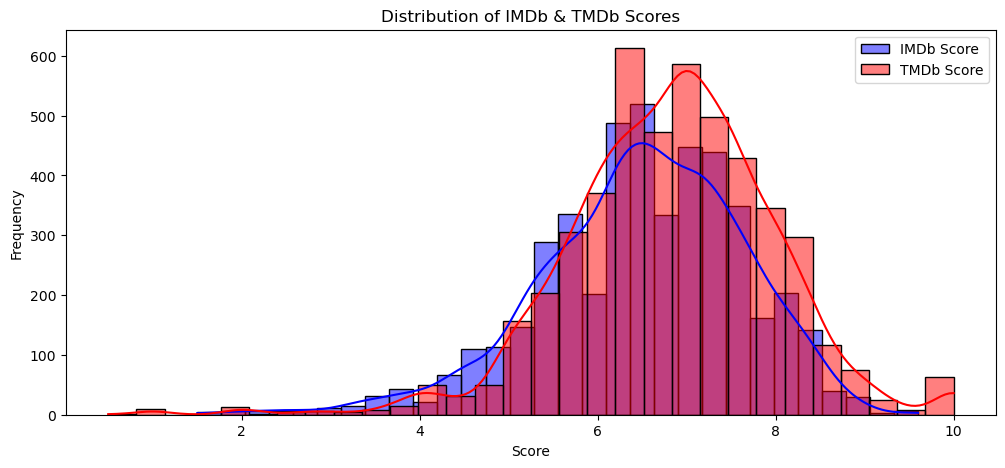

In [76]:
plt.figure(figsize=(12, 5))

sns.histplot(final_data['imdb_score'], bins=30, kde=True, color='blue', label='IMDb Score')
sns.histplot(final_data['tmdb_score'], bins=30, kde=True, color='red', label='TMDb Score')

plt.legend()
plt.title("Distribution of IMDb & TMDb Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_8904\3876315451.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_combine['Genre'], y=genre_combine['Count'], palette='viridis')


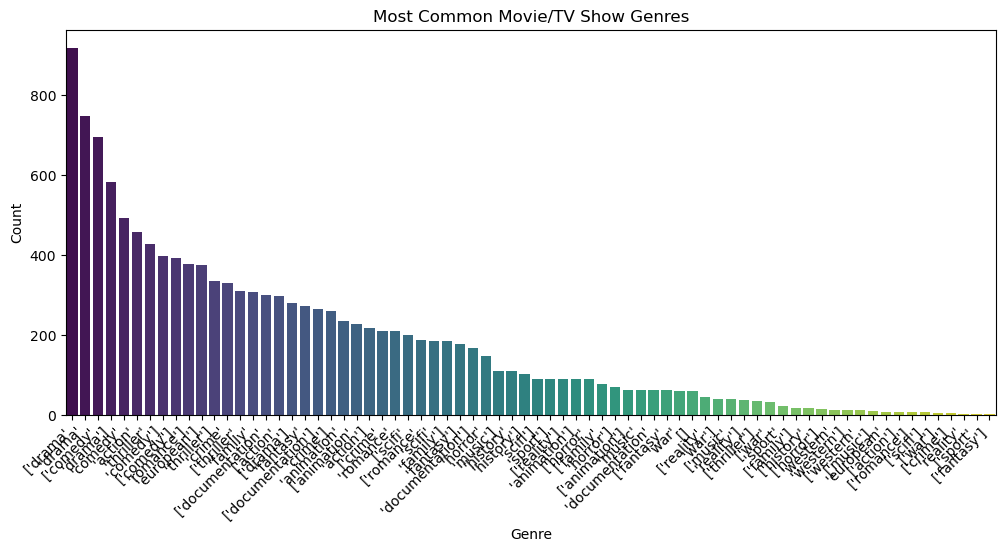

In [77]:
#show most popular genres
# Convert genres from string format to a list
all_genres = [genre for sublist in final_data['genres'].dropna().apply(lambda x: x.split(',')) for genre in sublist]

# Count occurrences
genre_counts = Counter(all_genres)

# Convert to DataFrame for visualization
genre_combine = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=genre_combine['Genre'], y=genre_combine['Count'], palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Most Common Movie/TV Show Genres")

plt.show()


C:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


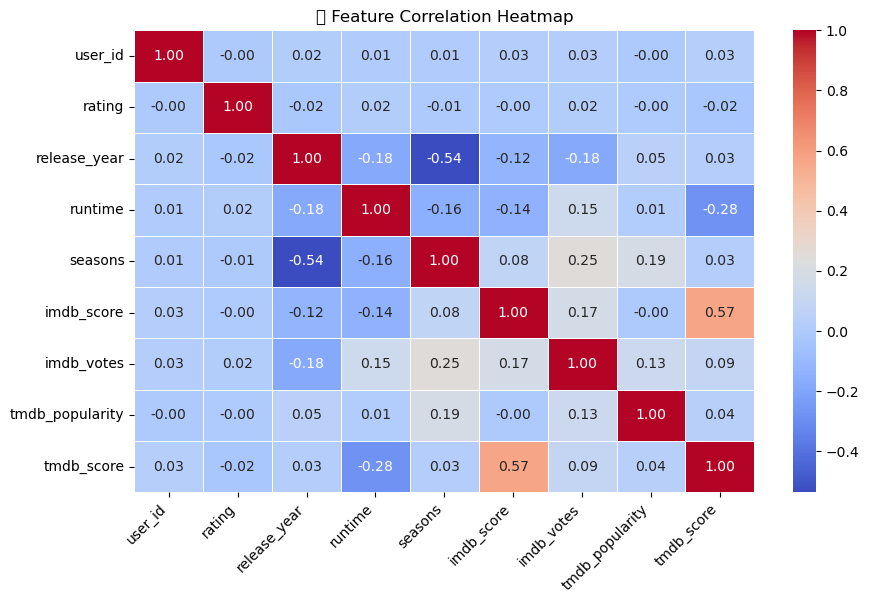

In [78]:
#remove redundant features
# Select only numerical columns from final_data
numeric_cols = final_data.select_dtypes(include=['number'])

# Compute correlation on numerical columns only
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("🔗 Feature Correlation Heatmap")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()


In [79]:
# Handle missing values 
final_data['title'] = final_data['title'].fillna('Unknown Title')
final_data['description'] = final_data['description'].fillna('No description available')
final_data['age_certification'] = final_data['age_certification'].fillna('Not Rated')
final_data['seasons'] = final_data['seasons'].fillna(0)
final_data['imdb_id'] = final_data['imdb_id'].fillna('Unknown')

# Fill numerical columns with appropriate statistics
final_data['imdb_score'] = final_data['imdb_score'].fillna(final_data['imdb_score'].mean())
final_data['tmdb_score'] = final_data['tmdb_score'].fillna(final_data['tmdb_score'].mean())
final_data['imdb_votes'] = final_data['imdb_votes'].fillna(final_data['imdb_votes'].median())
final_data['tmdb_popularity'] = final_data['tmdb_popularity'].fillna(final_data['tmdb_popularity'].median())

# Fill missing credits data
final_data[['person_id', 'name', 'character', 'role']] = final_data[['person_id', 'name', 'character', 'role']].fillna('Unknown')

# Fill missing user data
final_data['user_id'] = final_data['user_id'].fillna('Unknown User')
final_data['rating'] = final_data['rating'].fillna(final_data['rating'].median())  # Assuming ratings are numeric

# Print remaining missing values
print(final_data.isna().sum())
print(final_data.dtypes)


user_id                 0
id                      0
rating                  0
title                   0
type                    0
description             0
release_year            0
age_certification       0
runtime                 0
genres                  0
production_countries    0
seasons                 0
imdb_id                 0
imdb_score              0
imdb_votes              0
tmdb_popularity         0
tmdb_score              0
person_id               0
name                    0
character               0
role                    0
dtype: int64
user_id                   int64
id                       object
rating                    int64
title                    object
type                     object
description              object
release_year              int64
age_certification        object
runtime                   int64
genres                   object
production_countries     object
seasons                 float64
imdb_id                  object
imdb_score              f

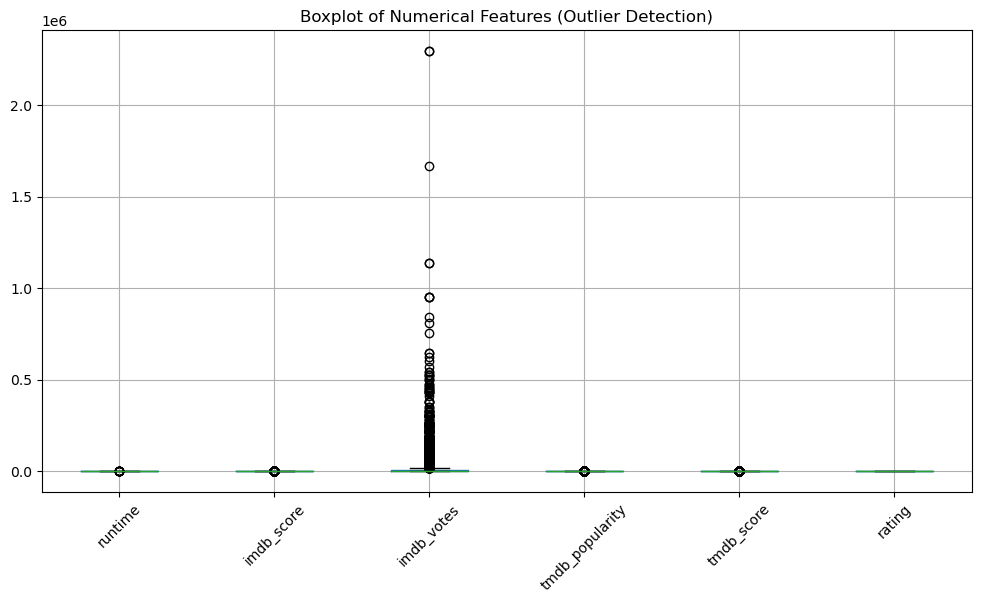

In [80]:
# Selecting numerical features
num_features = ['runtime', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score', 'rating']

# outlier detection
plt.figure(figsize=(12, 6))
final_data[num_features].boxplot()
plt.title("Boxplot of Numerical Features (Outlier Detection)")
plt.xticks(rotation=45)
plt.show()


In [81]:
train, test = train_test_split(final_data, test_size=0.2, random_state=42)

# Outlier detection using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Apply outlier removal only to training set
num_features = ['imdb_score', 'imdb_votes', 'tmdb_score', 'tmdb_popularity', 'rating']

for col in num_features:
    outliers = detect_outliers_iqr(train, col)
    train = train.drop(outliers.index)

print("Training dataset shape after outlier removal:", train.shape)

Training dataset shape after outlier removal: (2819, 21)


In [82]:
# Initialize the scaler
scaler = MinMaxScaler()

# List of numerical features to normalize
num_features = ['imdb_score', 'imdb_votes', 'tmdb_score', 'tmdb_popularity']

# Fit on training data and transform both train and test sets
train.loc[:, num_features] = scaler.fit_transform(train[num_features])
test.loc[:, num_features] = scaler.transform(test[num_features])

In [110]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

#  text preprocessing
def preprocess_text(text):
    if pd.isnull(text):
        return "unknown"  # Handle missing text
    
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers to keep only letters and spaces

    # Tokenization 
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # If all tokens are stop words or the text becomes empty, return "unknown" to avoid empty text
    if not tokens:
        return "unknown"
    
    return ' '.join(tokens)
    
# Apply preprocessing to the training and test sets' textual columns
train['description'] = train['description'].apply(preprocess_text)
test['description'] = test['description'].apply(preprocess_text)

train['title'] = train['title'].apply(preprocess_text)
test['title'] = test['title'].apply(preprocess_text)

train['character'] = train['character'].apply(lambda x: preprocess_text(str(x)))
test['character'] = test['character'].apply(lambda x: preprocess_text(str(x)))

print(train[['title', 'description', 'character']].head())
print(test[['title', 'description', 'character']].head())

# Create combined text-based features for TF-IDF processing
train['text_features'] = (
    train['genres'].fillna('') + " " +
    train['production_countries'].fillna('') + " " +
    train['description'].fillna('')
)

test['text_features'] = (
    test['genres'].fillna('') + " " +
    test['production_countries'].fillna('') + " " +
    test['description'].fillna('')
)

# Apply TF-IDF Vectorization 
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, min_df=1) #min_df can be increased for more rigorous text filtering

# Remove rows with empty text features
train = train[train['text_features'].str.strip() != '']
test = test[test['text_features'].str.strip() != '']

# Apply TF-IDF 
tfidf_matrix_train = tfidf.fit_transform(train['text_features'])
tfidf_matrix_test = tfidf.transform(test['text_features'])
print(f"TF-IDF Matrix Train Shape: {tfidf_matrix_train.shape}")
print(f"TF-IDF Matrix Test Shape: {tfidf_matrix_test.shape}")

# Select and scale numeric features
numeric_features = train[['release_year']].fillna(train[['release_year']].mean())  # Fill missing values with mean
scaler = MinMaxScaler()
numeric_scaled_train = scaler.fit_transform(numeric_features)
numeric_scaled_test = scaler.transform(test[['release_year']])

# Convert numeric features to sparse matrix format
numeric_scaled_train = csr_matrix(numeric_scaled_train)
numeric_scaled_test = csr_matrix(numeric_scaled_test)

# Combine text and numeric features into sparse matrices
combined_features_train = hstack([tfidf_matrix_train, numeric_scaled_train]).tocsr()
combined_features_test = hstack([tfidf_matrix_test, numeric_scaled_test]).tocsr()

# Handle nullvalues by replacing with 0 for sparse matrices
combined_features_train = combined_features_train.copy()
combined_features_train.data[np.isnan(combined_features_train.data)] = 0
combined_features_test = combined_features_test.copy()
combined_features_test.data[np.isnan(combined_features_test.data)] = 0

# Compute cosine similarity between training and  test samples
cosine_sim_train = cosine_similarity(combined_features_train, combined_features_train)
cosine_sim_test = cosine_similarity(combined_features_test, combined_features_test)

# Convert similarity matrix 
similarity_df_train = pd.DataFrame(cosine_sim_train, index=train.index, columns=train.index)
similarity_df_test = pd.DataFrame(cosine_sim_test, index=test.index, columns=test.index)

print(similarity_df_train.head())
print(similarity_df_test.head())


content_based_components = {
    'similarity_matrix': similarity_df_train,
    'content_features': final_data[['id', 'genres', 'production_countries', 'release_year', 'type']]
}
dump(content_based_components, 'content_model.joblib')

                                  title  \
4227                              jonas   
4676         bert kreischer secret time   
800                        centaurworld   
3671                         white girl   
4193  michelle buteau welcome buteaupia   

                                            description  \
4227  jonas met charismatic mysterious nathan additi...   
4676  comedian bert kreischer ready take shirt party...   
800   centaurworld follows war horse transported emb...   
3671  summer new york city college girl fall hard gu...   
4193  scenestealing queen michelle buteau dazzle rea...   

                                              character  
4227  jonas jonas teenager nathan nathans mother jon...  
4676                                                nan  
800   horse voice rider voice wammawink voice zulius...  
3671                                                nan  
4193                                           self nan  
                          title  \
150

['content_model.joblib']

In [84]:
#content-based

def get_recommendations(user_type=None, user_release_year=None, user_genres=None, user_countries=None, n=10):
    filtered_data = test.copy()

    if user_type:
        filtered_data = filtered_data[filtered_data['type'].str.contains(user_type, case=False, na=False)]
    if user_release_year:
        filtered_data = filtered_data[filtered_data['release_year'] == user_release_year]
    if user_genres:
        filtered_data = filtered_data[filtered_data['genres'].apply(lambda x: user_genres.lower() in [g.lower() for g in literal_eval(x)] if isinstance(x, str) else False)]
    if user_countries:
        filtered_data = filtered_data[filtered_data['production_countries'].str.contains(user_countries, case=False, na=False)]

    if filtered_data.empty:
        return "No matching movies found!"

    filtered_data = filtered_data.drop_duplicates(subset='title')
    
    similar_movies = pd.Series(dtype='float64')

    if 'similarity_df_test' in globals():  # Ensure similarity matrix exists
        for idx in filtered_data.index:
            if idx in similarity_df_test.index:
                similar_movies = similar_movies.add(similarity_df_test.loc[idx], fill_value=0)

    if similar_movies.empty:
        return "No similar movies found in the dataset!"
    
    similar_movies = similar_movies.sort_values(ascending=False)
    recommended_movies = test.loc[similar_movies.index, ['title', 'genres', 'rating']].drop_duplicates()

    if len(recommended_movies) < n:
        additional_recommendations = filtered_data[['title', 'genres', 'rating']].sort_values(by='rating', ascending=False).head(n - len(recommended_movies))
        recommended_movies = pd.concat([recommended_movies, additional_recommendations])
    
    # Sort final recommendations by rating in descending order
    recommended_movies = recommended_movies.sort_values(by='rating', ascending=False).head(n)

    return recommended_movies

# User Input
user_type = input("Enter movie type (Movie/Show) or press Enter to skip: ").strip() or None
user_release_year = input("Enter release year or press Enter to skip: ").strip()
user_release_year = int(user_release_year) if user_release_year else None
user_genres = input("Enter genres or press Enter to skip: ").strip() or None
user_countries = input("Enter production countries or press Enter to skip: ").strip() or None

recommended_movies = get_recommendations(user_type, user_release_year, user_genres, user_countries, n=10)

print("\nTop 10 recommended Movies for you:")
if isinstance(recommended_movies, str):
    print(recommended_movies)
else:
    for _, row in recommended_movies.iterrows():
        print(f"Movie Title: {row['title']}, Genres: {row['genres']}, Rating: {row.get('rating', 'N/A')}")

def evaluate_recommendations(y_true, y_pred):
    threshold = 3
    y_true_bin = [1 if rating >= threshold else 0 for rating in y_true]
    y_pred_bin = [1 if rating >= threshold else 0 for rating in y_pred]

    precision = precision_score(y_true_bin, y_pred_bin, zero_division=1)
    recall = recall_score(y_true_bin, y_pred_bin, zero_division=1)
    f1 = f1_score(y_true_bin, y_pred_bin, zero_division=1)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return {"RMSE": rmse, "Precision": precision, "F1-score": f1, "Recall": recall}

if isinstance(recommended_movies, str):
    print("No recommendations to evaluate.")
else:
    y_true = test['rating'].tolist()
    y_pred = recommended_movies['rating'].fillna(test['rating'].mean()).tolist()  # Use mean rating for missing values
    
    # Ensure the lengths match
    y_pred = y_pred[:len(y_true)] + [test['rating'].mean()] * (len(y_true) - len(y_pred))
    
    eval_metrics = evaluate_recommendations(y_true, y_pred)
    
    print("\nEvaluation Metrics:")
    for metric, value in sorted(eval_metrics.items(), key=lambda x: x[1], reverse=True):
        print(f"{metric}: {value:.4f}")


Enter movie type (Movie/Show) or press Enter to skip:  show
Enter release year or press Enter to skip:  
Enter genres or press Enter to skip:  
Enter production countries or press Enter to skip:  



Top 10 recommended Movies for you:
Movie Title: samouni road, Genres: ['animation', 'documentation', 'european'], Rating: 5
Movie Title: kingdom, Genres: ['action', 'scifi', 'thriller', 'history', 'drama', 'horror'], Rating: 5
Movie Title: legacy whitetail deer hunter, Genres: ['comedy', 'drama'], Rating: 5
Movie Title: ingobernable, Genres: ['war', 'crime', 'drama', 'thriller'], Rating: 5
Movie Title: debt collector, Genres: ['action', 'comedy'], Rating: 5
Movie Title: angelas christmas, Genres: ['family', 'animation'], Rating: 5
Movie Title: bye bye man, Genres: ['thriller', 'horror', 'fantasy', 'drama'], Rating: 5
Movie Title: worthy, Genres: ['thriller', 'action', 'scifi', 'fantasy', 'family', 'european'], Rating: 5
Movie Title: skylanders academy, Genres: ['action', 'animation', 'comedy', 'family', 'fantasy'], Rating: 5
Movie Title: american factory conversation obamas, Genres: ['documentation'], Rating: 5

Evaluation Metrics:
RMSE: 1.4605
Precision: 0.3000
F1-score: 0.0101
Recal

In [85]:
#collaborative-filtering
!pip install -U setuptools wheel
!pip install scikit-surprise


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from collections import defaultdict

# loaded final_data 
if 'final_data' not in globals():
    raise ValueError("Error: 'final_data' dataset is not defined.")

# Create user-item matrix
user_item_matrix = final_data.pivot_table(index='user_id', columns='id', values='rating')

# Fill missing values with median ratings
user_item_matrix_filled = user_item_matrix.apply(lambda x: x.fillna(x.median()), axis=0)

# Convert to long format
long_format = final_data[['user_id', 'id', 'rating']].dropna(subset=['rating'])

# Prepare dataset for Surprise
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(long_format[['user_id', 'id', 'rating']], reader)

# Split data (80-20)
trainset, testset = train_test_split(dataset, test_size=0.2)

# Hyperparameter tuning
param_grid = {
    'n_factors': [50, 100, 150],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
grid_search.fit(dataset)

print("Best Parameters:", grid_search.best_params['rmse'])
print("Best RMSE Score:", grid_search.best_score['rmse'])

# Train best model
best_svd = grid_search.best_estimator['rmse']
best_svd.fit(trainset)

# Evaluate model
predictions = best_svd.test(testset)
rmse = accuracy.rmse(predictions, verbose=False)
print(f"RMSE: {rmse:.4f}")

# evaluation matric Calculation
def precision_recall_at_k(predictions, k=5, threshold=3.0):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = [], []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(reverse=True, key=lambda x: x[0])
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for (est, true_r) in user_ratings[:k])
        
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k else 0
        recall = n_rel_and_rec_k / n_rel if n_rel else 0
        precisions.append(precision)
        recalls.append(recall)
    
    precision_avg = np.mean(precisions)
    recall_avg = np.mean(recalls)
    f1_score_avg = (2 * precision_avg * recall_avg / (precision_avg + recall_avg)) if (precision_avg + recall_avg) else 0
    
    return precision_avg, recall_avg, f1_score_avg

precision, recall, f1_score = precision_recall_at_k(predictions, k=5, threshold=3.0)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1_score:.4f}")

# Recommendation function
def recommend_for_user(user_id, n_recommendations=5):
    if user_id not in user_item_matrix.index:
        return [("User not found in dataset", None, None)]

    all_items = final_data['id'].unique()
    rated_items = user_item_matrix.loc[user_id].dropna().index
    items_to_predict = [item for item in all_items if item not in rated_items]
    
    if not items_to_predict:
        return [("No new recommendations available", None, None)]
    
    predictions = [best_svd.predict(user_id, item_id) for item_id in items_to_predict]
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    top_n_recommendations = predictions[:n_recommendations]
    
    # Move the recommended_movies inside the function properly
    recommended_items = [
        (
            pred.iid,  
            final_data.loc[final_data['id'] == pred.iid, 'title'].values[0] if not final_data.loc[final_data['id'] == pred.iid, 'title'].empty else "Unknown Title",
            round(pred.est, 1)
        ) for pred in top_n_recommendations
    ]
    
    return recommended_items  


# Get user input
try:
    user_id_input = int(input("Enter your user ID: ").strip())
    top_recommendations = recommend_for_user(user_id_input, n_recommendations=10)
    
    print("\nTop 10 recommended items:")
    
    for item_id, movie_title, predicted_rating in top_recommendations:
        print(f"Item ID: {item_id}, Movie Title: {movie_title}, Predicted Rating: {predicted_rating}")

except ValueError:
    print("Invalid input! Please enter a valid numeric user ID.")

# Save the trained SVD model
dump(best_svd, 'collaborative_model.joblib')

Best Parameters: {'n_factors': 50, 'lr_all': 0.002, 'reg_all': 0.2}
Best RMSE Score: 1.4292832339142008
RMSE: 1.4058
Precision: 0.3657, Recall: 0.3974, F1-score: 0.3809


Enter your user ID:  101



Top 10 recommended items:
Item ID: tm877681, Movie Title: American Pie Presents: Girls' Rules, Predicted Rating: 3.3
Item ID: tm450769, Movie Title: Nathicharami, Predicted Rating: 3.3
Item ID: tm462809, Movie Title: The Wedding Shaman, Predicted Rating: 3.3
Item ID: ts20837, Movie Title: Outlander, Predicted Rating: 3.3
Item ID: ts42038, Movie Title: No Tomorrow, Predicted Rating: 3.3
Item ID: tm165712, Movie Title: Tim Minchin and the Heritage Orchestra: Live at the Royal Albert Hall, Predicted Rating: 3.3
Item ID: ts86165, Movie Title: The Society, Predicted Rating: 3.3
Item ID: tm138905, Movie Title: The Hateful Eight, Predicted Rating: 3.3
Item ID: tm469911, Movie Title: Bonnie & Clyde, Predicted Rating: 3.3
Item ID: ts86302, Movie Title: Check The Store Next Door, Predicted Rating: 3.3


['collaborative_model.joblib']

In [112]:
#weight hybrid system

# loaded final_data dataset
if 'final_data' not in globals():
    raise ValueError("Error: 'final_data' dataset is not defined.")

# Prepare data for Surprise
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(final_data[['user_id', 'id', 'rating']], reader)

# Train-Test Split (80-20)
trainset, testset = train_test_split(dataset, test_size=0.2)

# Train the best collaborative filtering model (SVD)
svd = SVD(n_factors=100, lr_all=0.005, reg_all=0.1)
svd.fit(trainset)

# Content-Based Filtering: Precompute Similarities
content_features = final_data[['id', 'title', 'genres', 'production_countries', 'release_year']]
content_features['genres'] = content_features['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else [])
content_features['production_countries'] = content_features['production_countries'].apply(lambda x: literal_eval(x) if isinstance(x, str) else [])

def compute_content_similarity(movie_id, user_genres, user_countries):
    """Compute content similarity score based on genres and production countries."""
    if movie_id not in content_features['id'].values:
        return 0  # If the movie is not found, return 0 similarity
    
    movie_row = content_features[content_features['id'] == movie_id].iloc[0]
    
    genre_similarity = len(set(movie_row['genres']) & set(user_genres)) / len(set(user_genres)) if user_genres else 0
    country_similarity = len(set(movie_row['production_countries']) & set(user_countries)) / len(set(user_countries)) if user_countries else 0
    
    return 0.7 * genre_similarity + 0.3 * country_similarity  # Weighted similarity

def hybrid_recommend_for_user(user_id, n_recommendations=10, weight_cf=0.6, weight_cbf=0.4, genre_filter=None, year_filter=None):
    # Check if the user exists in the dataset
    if user_id not in final_data['user_id'].values:
        print(" User not found in dataset. Recommending top movies instead.")
        all_items = final_data['id'].unique()  # Use all movies
    else:
        user_movies = final_data[final_data['user_id'] == user_id]

        # Extract user preferences (genres, countries)
        user_genres = list(set([genre for genres in user_movies['genres'].apply(literal_eval) for genre in genres if genres]))
        user_countries = list(set([country for countries in user_movies['production_countries'].apply(literal_eval) for country in countries if countries]))

        all_items = final_data['id'].unique()

    # Apply genre filter
    if genre_filter:
        genre_filter = genre_filter.lower()
        filtered_items = [
            item for item in all_items
            if any(genre_filter in g.lower() for g in literal_eval(final_data.loc[final_data['id'] == item, 'genres'].values[0]))
        ]
        if not filtered_items:
            print("No movies match the selected genre. Displaying top recommendations instead.")
        else:
            all_items = filtered_items

    # Apply year filter
    if year_filter:
        all_items = [
            item for item in all_items
            if final_data.loc[final_data['id'] == item, 'release_year'].values[0] == year_filter
        ]
        if not all_items:
            print(" No movies match the selected year. Displaying top recommendations instead.")

    # Ensure have movies to recommend
    if not all_items:
        return [("No recommendations available", None)]

    predictions = []
    
    for item_id in all_items:
        cf_score = svd.predict(user_id, item_id).est  # CF score
        cbf_score = compute_content_similarity(item_id, user_genres, user_countries)  # CBF score
        
        final_score = (weight_cf * cf_score) + (weight_cbf * cbf_score)  # Hybrid score
        predictions.append((item_id, final_score))

    predictions.sort(key=lambda x: x[1], reverse=True)  # Sort by highest score
    
    top_n_recommendations = predictions[:n_recommendations]

    recommended_items = [
        (
            pred[0],  # Movie ID
            final_data.loc[final_data['id'] == pred[0], 'title'].values[0] if not final_data.loc[final_data['id'] == pred[0], 'title'].empty else "Unknown Title"
        ) for pred in top_n_recommendations
    ]
    
    return recommended_items


#user input
try:
    user_id_input = int(input("Enter your user ID: ").strip())

    genre_input = input("Enter a movie genre to filter (or press Enter to skip): ").strip().lower()
    genre_filter = genre_input if genre_input else None

    year_input = input("Enter a release year to filter (or press Enter to skip): ").strip()
    year_filter = int(year_input) if year_input.isdigit() else None

    top_recommendations = hybrid_recommend_for_user(user_id_input, n_recommendations=10, genre_filter=genre_filter, year_filter=year_filter)
    
    print("\nTop 10 recommended movie:")
    
    for item_id, movie_title in top_recommendations:
        predicted_rating = svd.predict(user_id_input, item_id).est  # Get predicted rating
        print(f" Movie Title: {movie_title}(Predicted Rating: {predicted_rating:.2f})")

except ValueError:
    print("Invalid input! Please enter a valid numeric user ID.")

# Evaluation
test_predictions = svd.test(testset)

# Define threshold for relevant recommendations
threshold = 3.5 
k = 10  # Top-K recommendations

# Group predictions by user
user_est_true = defaultdict(list)
for uid, _, true_r, est, _ in test_predictions:
    user_est_true[uid].append((est, true_r))

# Compute RMSE and MAE once
rmse = accuracy.rmse(test_predictions)
mae = accuracy.mae(test_predictions)

# Compute Precision and Recall
precision_list = []
recall_list = []

for uid, ratings in user_est_true.items():
    ratings.sort(key=lambda x: x[0], reverse=True)  # Sort by predicted rating (desc)
    top_k = ratings[:k]  # Get Top-K items
    
    relevant_items = sum((true_r >= threshold) for (_, true_r) in ratings)  # Actual good items
    recommended_relevant = sum((true_r >= threshold) for (_, true_r) in top_k)  # Recommended good items

    precision = recommended_relevant / k if k > 0 else 0
    recall = recommended_relevant / relevant_items if relevant_items > 0 else 0

    precision_list.append(precision)
    recall_list.append(recall)

# Average Precision and Recall
precision = sum(precision_list) / len(precision_list) if precision_list else 0
recall = sum(recall_list) / len(recall_list) if recall_list else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#Ensure RMSE & MAE are displayed only once
print("\nModel Evaluation Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

hybrid_components = {
    'svd_model': best_svd,
    'genre_weights': (0.7, 0.3)
}
dump(hybrid_components, 'hybrid_model.joblib')

C:\Users\User\AppData\Local\Temp\ipykernel_8904\3700011725.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_features['genres'] = content_features['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else [])
C:\Users\User\AppData\Local\Temp\ipykernel_8904\3700011725.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_features['production_countries'] = content_features['production_countries'].apply(lambda x: literal_eval(x) if isinstance(x, str) else [])


Enter your user ID:  111
Enter a movie genre to filter (or press Enter to skip):  
Enter a release year to filter (or press Enter to skip):  


Invalid input! Please enter a valid numeric user ID.
RMSE: 1.4488
MAE:  1.2486

Model Evaluation Metrics:
RMSE: 1.4488
MAE: 1.2486
Precision: 0.0617
Recall: 0.5102
F1-Score: 0.1101


['hybrid_model.joblib']